<a href="https://colab.research.google.com/github/skumarudel/DSPS_SKumar/blob/master/HW10/AutoEncoders_OnFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import cv2   # mostly to downsample an image
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/Shareddrives/DSPS2021

/content/gdrive/Shareddrives/DSPS2021


In [4]:
!ls

10802534_761689917241346_821292660_n.jpg  galaxies.npy
ak0.png					  higgsb
ak1.png					  images_test_rev1.zip
ak2.png					  images_training_rev1
ak3.png					  images_training_rev1.zip
ak4.png					  kaggleTitanic
all_ones_benchmark.zip			  nyzipcodes
all_zeros_benchmark.zip			  training_solutions_rev1.csv
central_pixel_benchmark.zip		  training_solutions_rev1.zip
data					  uo_img.jpg


# Read the data

In [5]:
flist = glob.glob("data/faces95/*jpg")
N = len(flist)
print(N)

1440


((70, 70, 1), 540)

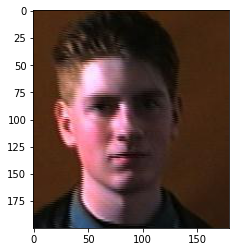

In [6]:
im = Image.open(flist[40])
np_im = np.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

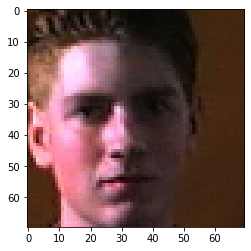

In [7]:
pl.imshow(np_im[25:165:2,25:165:2])

In [8]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i,f in enumerate(flist):
  if not i%50: print(i)
  im = Image.open(flist[i])
  np_im = np.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = np.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


In [ ]:
# I just saved it to my own directroy
np.save("/content/gdrive/MyDrive/machine_learning_course/autoencoders/faces_saved.npy", imgs)

In [9]:
imgs = np.load("data/faces.npy")
imgs.shape

(1440, 70, 70, 1)

# Change Resolution of data for fast processing

In [60]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [61]:
imgs.shape

(1440, 70, 70, 1)

In [12]:
# lower the resolution
# example: take one every N pixels
imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
#imgs_lr = imgs.reshape(...).mean(...).mean(...)
imgs_lr.shape

(1440, 35, 35, 1)

In [13]:
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

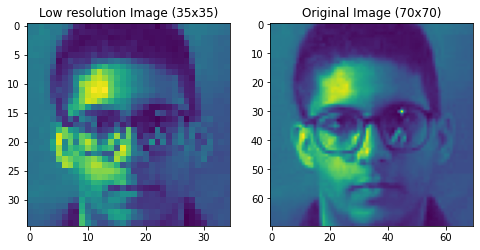

In [14]:
fig,axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(imgs_lr[55].reshape(35,35))
axes[0].set_title("Low resolution Image (35x35)")
axes[1].imshow(imgs[55].reshape(70,70))
axes[1].set_title("Original Image (70x70)");

## Creating Training and Test data sets

In [15]:
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs, test_size=0.30, random_state=69)

In [16]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1008, 35, 35, 1), (432, 35, 35, 1), (1008, 70, 70, 1), (432, 70, 70, 1))

In [17]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [18]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1008, 1225), (432, 1225), (1008, 4900), (432, 4900))

In [19]:
xshape = X_tr.shape[1]  # input dimension
ndim = y_tr.shape[1]   # output dimension

In [21]:
xshape, ndim

(1225, 4900)

In [22]:
model_face = Sequential()
## encoder
model_face.add(Dense(256, activation='relu', input_dim=xshape))
# input layer and the output size
model_face.add(Dense(128, activation='relu', input_dim=xshape))
#compression layer
model_face.add(Dense(64, activation='relu'))
## deencoder
#decompression layer, same size as in the encoder
#model_face.add(Dense(128, activation='relu'))
#output layer, same size as input
model_face.add(Dense(256, activation='relu'))
#output layer, same size as input
model_face.add(Dense(ndim, activation='sigmoid'))

In [23]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model_face.compile(optimizer=opt, loss="binary_crossentropy")
print(model_face.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 4900)              1259300   
                                                                 
Total params: 1,630,948
Trainable params: 1,630,948
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
history_face = model_face.fit(X_tr, y_tr,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(X_te, y_te),callbacks=[callback])


Epoch 1/500
16/16 [==============================] - 3s 24ms/step - loss: 0.6415 - val_loss: 0.6139
Epoch 2/500
16/16 [==============================] - 0s 12ms/step - loss: 0.6068 - val_loss: 0.6006
Epoch 3/500
16/16 [==============================] - 0s 10ms/step - loss: 0.5960 - val_loss: 0.5907
Epoch 4/500
16/16 [==============================] - 0s 12ms/step - loss: 0.5858 - val_loss: 0.5773
Epoch 5/500
16/16 [==============================] - 0s 9ms/step - loss: 0.5727 - val_loss: 0.5653
Epoch 6/500
16/16 [==============================] - 0s 10ms/step - loss: 0.5637 - val_loss: 0.5575
Epoch 7/500
16/16 [==============================] - 0s 12ms/step - loss: 0.5574 - val_loss: 0.5526
Epoch 8/500
16/16 [==============================] - 0s 10ms/step - loss: 0.5546 - val_loss: 0.5516
Epoch 9/500
16/16 [==============================] - 0s 10ms/step - loss: 0.5523 - val_loss: 0.5543
Epoch 10/500
16/16 [==============================] - 0s 10ms/step - loss: 0.5513 - val_loss: 0.5508


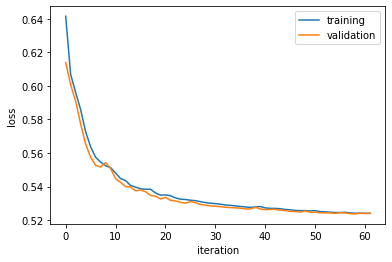

In [25]:
pl.plot(np.array(history_face.history['loss']), label="training")
pl.plot(np.array(history_face.history['val_loss']), label="validation")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend();
#pl.yscale('log')
#pl.xscale('log')

In [26]:
output_image = model_face.predict(X_te)

In [27]:
output_image.shape

(432, 4900)

In [156]:
def compareinout(i, outim, testimg, actualimage, initialshape=(int(np.sqrt(X_tr.shape[1])), int(np.sqrt(X_tr.shape[1])))):
  fig = plt.figure(figsize=(15,5))
  ax = fig.add_subplot(131) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('Input image (35 by 35)')
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(int(initialshape[0]*2), int(initialshape[1]*2)) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('Predicted image by model (70 by 70)')
  ax = fig.add_subplot(133) 
  ax.imshow(actualimage[i].reshape(int(initialshape[0]*2), int(initialshape[1]*2)) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('Actual target image (70 by 70)')

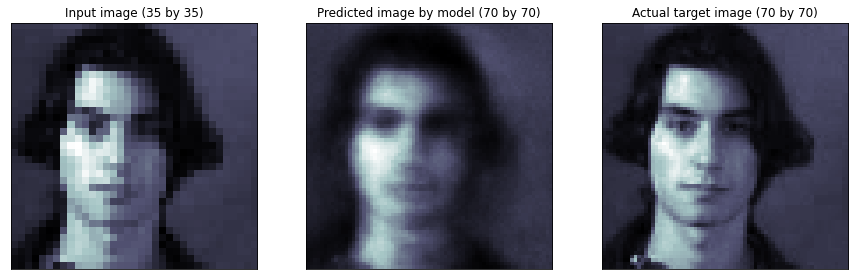

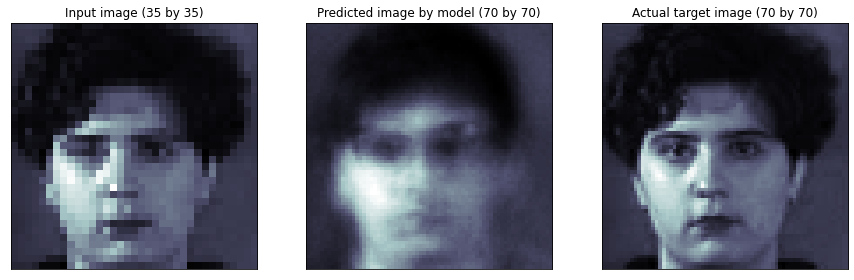

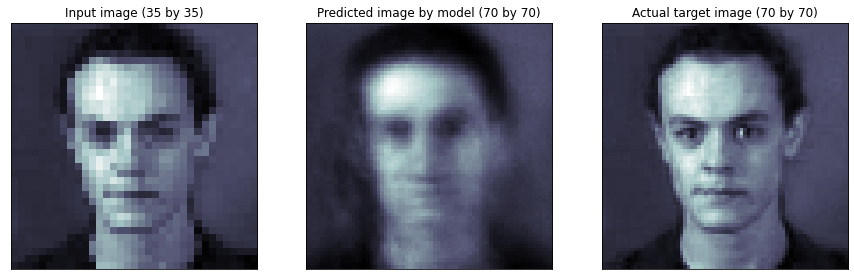

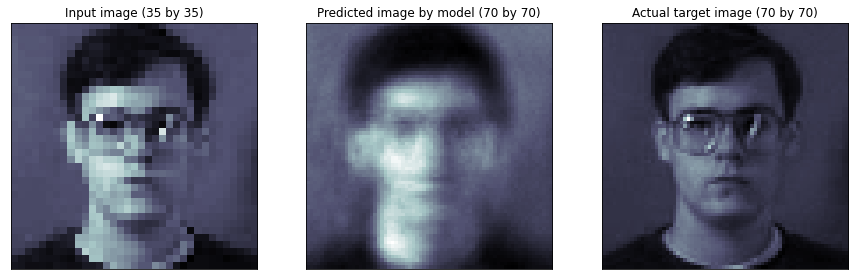

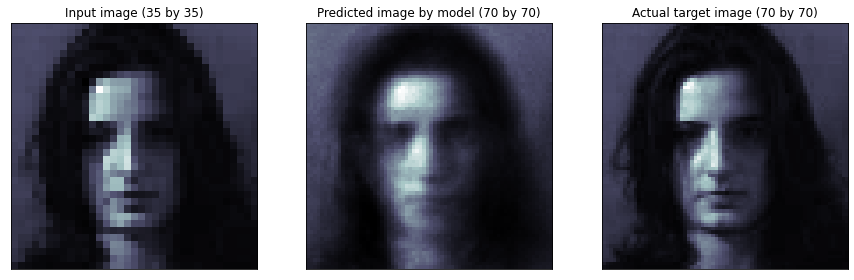

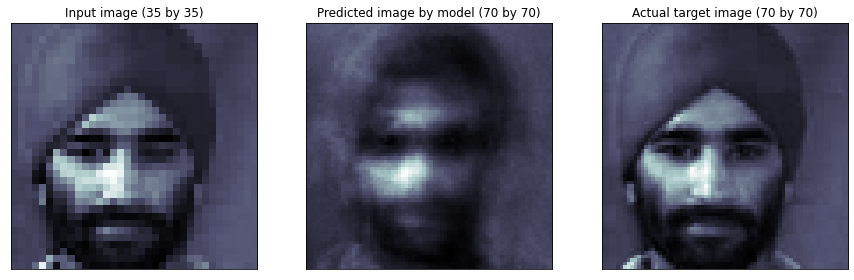

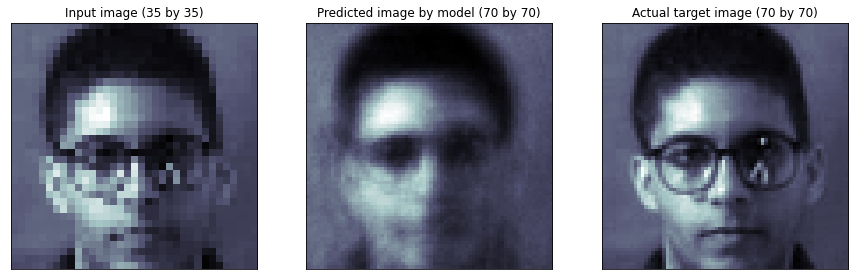

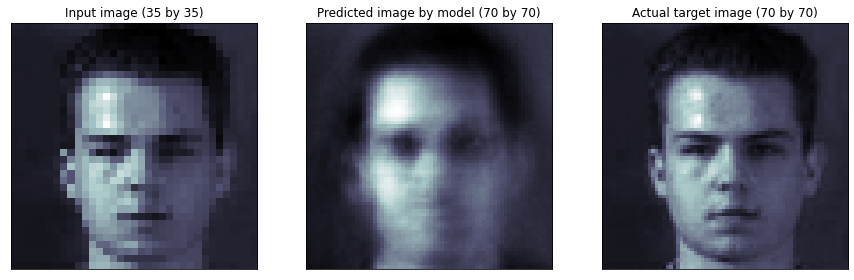

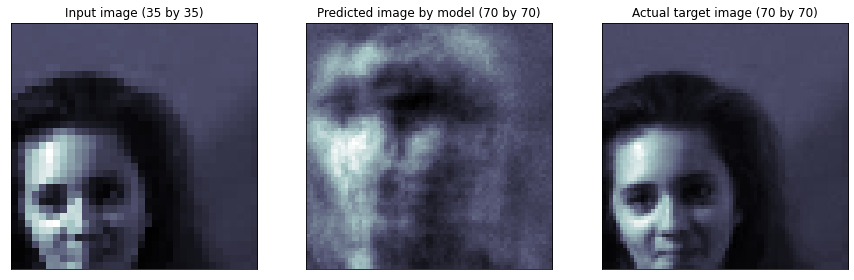

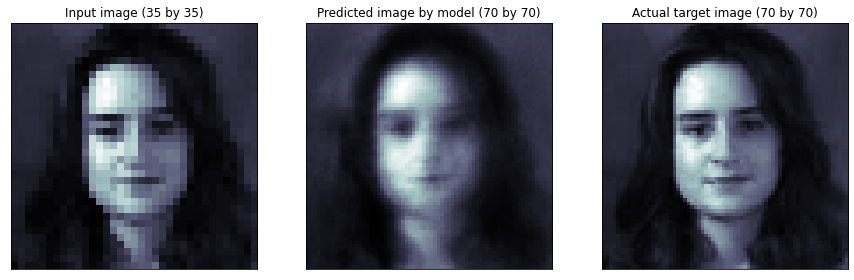

In [157]:
np.random.seed(20)
sample_images = np.random.choice(len(X_te), 10, replace=False)
for sample in sample_images:
  compareinout(sample, output_image, X_te, y_te)


# Trying it on my own image

In [109]:
my_image_path = '/content/gdrive/MyDrive/machine_learning_course/autoencoders/Sajan_Pic.png' 

(403, 403, 3)

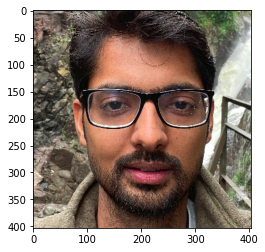

In [114]:
im_my = Image.open(my_image_path)
np_im_my = np.array(im_my)[30:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im_my)
# I am going to need only a subset of the image: the center part where the head is

np_im_my.shape

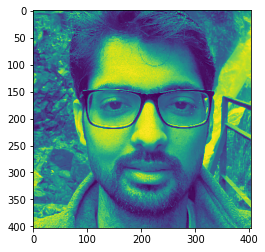

In [115]:
plt.imshow(np_im[:,:, 0]);  # plotting only red channel

## Downsample image to 35 by 35 to give as a input to autoencoder

In [119]:
resized_image = cv2.resize(np_im_my, (35, 35)) 
resized_image = resized_image[:,:,0].reshape(35*35)
resized_image = resized_image.reshape(1,1225)

## Pass it thourgh the autoencoder model

In [120]:
output_myimage = model_face.predict(resized_image)

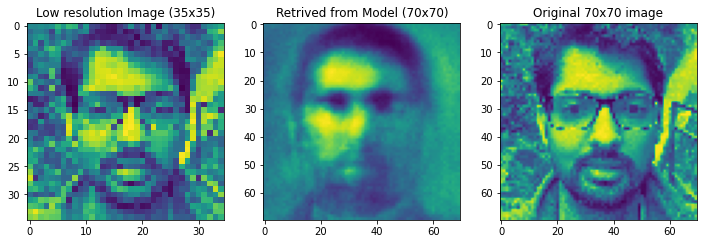

In [121]:
fig,axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow(resized_image.reshape(35,35))
axes[0].set_title("Low resolution Image (35x35)")
axes[1].imshow(output_myimage.reshape(70,70))
axes[1].set_title("Retrived from Model (70x70)")

axes[2].imshow(cv2.resize(np_im_my, (70, 70))[:,:,0] )
axes[2].set_title("Original 70x70 image");



# Extracting the bottleneck layer

In [129]:
# input placeholder
inp = model_face.input                   
# extract the bottle neck outputs
outputs = model_face.layers[2].output     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(X_te[:1])


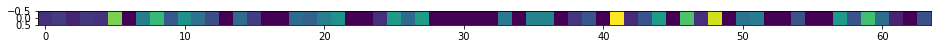

In [136]:
plt.figure(figsize=(16,4))
plt.imshow(layer_outs[0]);

## Another represnetation (64--> 8 by 8)

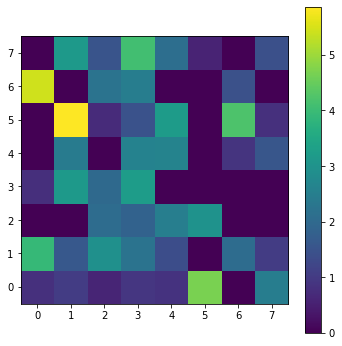

In [142]:
plt.figure(figsize=(6,6))
plt.imshow(layer_outs[0].reshape(8,8), origin='lower')
plt.colorbar();